In [1]:
%reset -sf

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
!pip install -U scikit-learn

     |████████████████████████████████| 24.8 MB 4.4 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.0 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.


In [4]:
# Patch Xeon Intel OneAPI Scikit accelerator
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

     |████████████████████████████████| 69 kB 2.2 MB/s             
     |████████████████████████████████| 22.5 MB 15.2 MB/s            
     |████████████████████████████████| 284.3 MB 1.9 kB/s              
     |████████████████████████████████| 4.0 MB 44.4 MB/s            


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
from numpy import array, linspace, mean, column_stack, min as np_min, max as np_max
from pandas import read_parquet, DataFrame, Series, to_datetime, concat
from pathlib import Path
from itertools import cycle
from random import randint
from gc import collect
from joblib import dump, load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from deap import creator as ga_cr, base as ga_b, algorithms as ga_algo, tools as ga_t

In [6]:
p = Path().cwd()
p = p.parent
p = p / 'input' / 'kaggle-pog-series-s01e01'

train = read_parquet(p / 'train.parquet')
test = read_parquet(p / 'test.parquet')

<AxesSubplot:ylabel='Frequency'>

0.0570600551836053

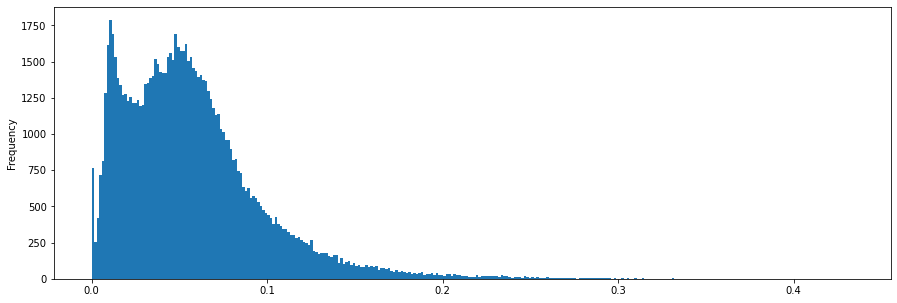

In [7]:
# Train y
(train['likes'] / train['view_count']).plot(kind='hist', bins=int(len(train)**0.5), figsize=(15,5))
(train['likes'] / train['view_count']).mean()

<AxesSubplot:ylabel='Frequency'>

0.0570600551836053

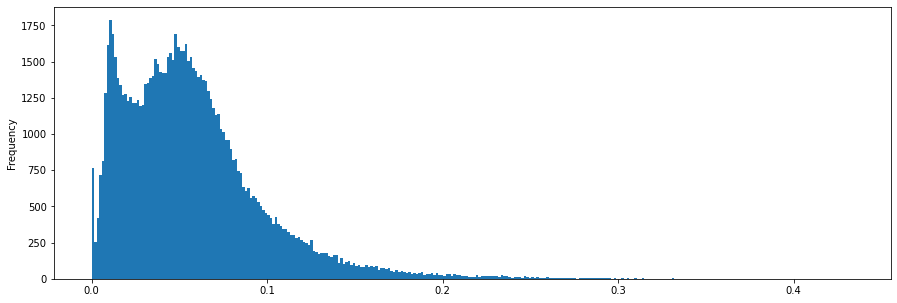

In [8]:
# Train y
(train['target']).plot(kind='hist', bins=int(len(train)**0.5), figsize=(15,5))
(train['target']).mean()

In [9]:
def clean_train(df):
    df['publishedAt'] = to_datetime(df['publishedAt'], errors='coerce').dt.tz_localize(None)
    df['trending_date'] = to_datetime(df['trending_date'], errors='coerce').dt.tz_localize(None) 
    return df
    
train = clean_train(train)
test = clean_train(test)

In [10]:
def feat_eng(df):
    df['t_delta'] = (df['trending_date'] - df['publishedAt']).dt.seconds
    # TODO
    # add day of week, categoryid, 
    """df['channel_occurance'] = df['channelId'].map(
        df['channelId'].value_counts().to_dict())

    df['channel_unique_video_count'] = df['channelId'].map(
        df.groupby('channelId')['video_id'].nunique().to_dict())
    
    df['video_occurance_count'] = df.groupby('video_id')['trending_date'] \
        .rank().astype('int')channel freq, """
    return df

train = feat_eng(train)
test = feat_eng(test)

In [11]:
def prep_data(params, train_df, train_data=True):
    train_X = train_df[['title', 'duration_seconds', 't_delta']].copy()

    cv_params = {k:v for k,v in params.items() if k != 'q'}
    cv_params = {**cv_params, **{'strip_accents': 'ascii',
                                 'lowercase': True,
                                 'stop_words': 'english',
                                 'analyzer': 'word',
                                 #'token_pattern': '(?u)\b\w\w\w+\b',  # 3 or more letters
                                 }}
    #cv = CountVectorizer(**)
    tdf = TfidfVectorizer(**cv_params)
    
    q_param = {k:v for k,v in params.items() if k == 'q'}
    q = train_X['duration_seconds'].quantile(**q_param)
    mask = train_X['duration_seconds'].isna()
    train_X.loc[mask, 'duration_seconds'] = q
    
    mms = MinMaxScaler()
    
    train_X = column_stack((
        tdf.fit_transform(train_X['title']).toarray(),
        mms.fit_transform(train_X[['duration_seconds']]),
        mms.fit_transform(train_X[['t_delta']]),
    ))
    
    if train_data:
        train_y = train_df['target']
        return train_X, train_y
    else:
        return train_X

In [12]:
class GA_Scikit():
    def __init__(self, 
                 estimator, 
                 #
                 params, 
                 eval_func, 
                 eval_weights, 
                 #
                 train_df, 
                 #valid_df, 
                 score, 
                 #
                 sel_tournsize=2, 
                 cx_uniform_prob=0.5, 
                 mut_shuffle_idx_prob=0.1, 
                 n_pop=30, 
                 n_gen=10, 
                 n_hof=1, 
                 cx_prob=0.5, 
                 mut_prob=0.1, 
                 n_jobs=3  # not good with HistGradBoosReg...
                ):
        
        self.est = estimator
        self.params = params
        self.eval_func = eval_func
        self.eval_weights = eval_weights
        #
        self.train_df = train_df
        #self.valid_df = valid_df
        self.score = score
        #
        self.sel_tournsize = sel_tournsize
        self.cx_uniform_prob = cx_uniform_prob
        self.mut_shuffle_idx_prob = mut_shuffle_idx_prob
        self.n_pop = n_pop
        self.n_gen = n_gen
        self.n_hof = n_hof
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.n_jobs = n_jobs
        
        self._pad_params()
        self._create_fitness_and_indiv()
        self._register_indiv_and_pop_generators()
        self._calc_baseline_and_overfit()
        self._register_eval_func()
        self._register_selection_crossover_mutation_methods()
        
    def _pad_params(self):
        """Pad params for crossover shuffle idx method"""
        assert isinstance(self.params, dict), 'Params must be a dict, i.e. estimator.get_params()'
        params_count = {k: len(v) for k,v in self.params.items()}
        max_length, max_key = -99, ''
        for k, v in params_count.items():
            if v <= max_length:
                continue
            else:
                max_key = k
                max_length = v
        assert isinstance(max_length, int), 'The max length between all params must be an int'
        # cycle through params for max length param, otherwise infinite cycle
        values_padded = (cycle(v) if k!=max_key else v for k,v in self.params.items())
        values_padded = zip(*values_padded)  # ('a', 1, 14), ('b', 2, 16), ('c', 3, 16) ...
        values_padded = zip(*values_padded)  # ('a', 'b', 'c'), (1, 2, 3), (14, 15, 16)...
        padded_params = {}
        for k, v in zip(self.params, values_padded):
            padded_params[k] = v
        self.padded_params = padded_params
        
    def _create_fitness_and_indiv(self):
        """Create GA individual and fitness entities (classes)"""
        ga_cr.create('Fitness', ga_b.Fitness, weights=self.eval_weights)
        ga_cr.create('Individual', list, fitness=ga_cr.Fitness)

    def _gen_params_to_ga(self):
        """Generate index for each param for individual"""
        max_dict = len(self.padded_params)
        max_length = len(list(self.padded_params.values())[0])
        idxs = [randint(0, max_length-1) for _ in range(max_dict)]
        return idxs
            
    def _register_indiv_and_pop_generators(self):
        """Register GA individual and population generators"""
        self.tb = ga_b.Toolbox()

        if self.n_jobs > 1:
            from multiprocessing import Pool
            pool = Pool()
            self.tb.register("map", pool.map)

        self.tb.register("individual", ga_t.initIterate, ga_cr.Individual, self._gen_params_to_ga)
        #print('indiv', self.tb.individual())
        self.tb.register("population", ga_t.initRepeat, list, self.tb.individual)
        #print('population', self.tb.population(n=2))
        
    def _calc_baseline_and_overfit(self):
        # Individual
        indiv = [1]*len(self.tb.individual())

        # Params
        cv_params = {k : list(v)[idx] for (k,v), idx in zip(self.padded_params.items(), indiv) if k not in 
                 ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state']}
    
        # Data
        train_X, train_y = prep_data(cv_params, self.train_df, train_data=True)
        train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.8)
        
        # Baseline
        self.plain_mean = train_y.mean()
        self.plain_mean = [self.plain_mean]*len(valid_y)
        self.plain_mean = self.score(valid_y, self.plain_mean)
        print(f'Plain mean score: {self.plain_mean}')
        
        # Overfit
        est = self.est(random_state=16)
        _ = est.fit(train_X, train_y)
        self.overfit = est.predict(valid_X)
        self.overfit = self.score(valid_y, self.overfit)
        print(f'Overfit score: {self.overfit}')
        
        del train_X, valid_X, train_y, valid_y
            
    def _register_eval_func(self):
        """Set GA evaluate individual function"""
        self.tb.register("evaluate",
                        self.eval_func,
                        padded_params=self.padded_params,
                        est=self.est,
                        train_df=self.train_df, 
                        plain_mean=self.plain_mean,
                        overfit=self.overfit,
                        score=self.score
                        )
        #print(list(self.tb.evaluate(indiv) for indiv in self.tb.population(3)))
        
    def _register_selection_crossover_mutation_methods(self):
        """Register GA select/mate/mutate methods"""
        self.tb.register("select", ga_t.selTournament, tournsize=self.sel_tournsize)
        self.tb.register("mate", ga_t.cxUniform, indpb=self.cx_uniform_prob)
        self.tb.register("mutate", ga_t.mutShuffleIndexes, indpb=self.mut_shuffle_idx_prob)

    def run_ga_search(self):
        """Run search"""
        pop = self.tb.population(n=self.n_pop)
        hof = ga_t.HallOfFame(self.n_hof)

        # Stats stdout
        #stats = ga_t.Statistics(lambda ind: ind.fitness.values )
        stats1 = ga_t.Statistics(lambda ind: ind.fitness.values[0] )
        stats2 = ga_t.Statistics(lambda ind: ind.fitness.values[1] )
        #stats3 = ga_t.Statistics(lambda ind: ind.fitness.values[2] )
        stats = ga_t.MultiStatistics(dist1=stats1, dist2=stats2)
        stats.register("avg", mean)
        stats.register("min", np_min)
        
        # GA Run
        pop, log = ga_algo.eaSimple(pop, self.tb, cxpb=self.cx_prob, 
                                    mutpb=self.mut_prob, ngen=self.n_gen, 
                                    stats=stats, halloffame=hof, verbose=True)
        
        # Convert back params
        hof_ = {}
        for i in range(self.n_hof):
            hof_['hof_' + str(i)] = self._ga_to_params(hof[i])

        return pop, log, hof_
    
    def _ga_to_params(self, idx_params):
        """Helper to convert to readable params"""
        res = {}
        for (k,v), idx in zip(self.padded_params.items(), idx_params):
            res[k] = v[idx]
        return res

In [13]:
# Estimator, params and requirements

est = RandomForestRegressor
est = DecisionTreeRegressor
est = GradientBoostingRegressor

params = {
             'n_estimators': linspace(2,50,20).astype(int),
            # 'criterion': ['squared_error', 'absolute_error'],
             'max_depth': linspace(2,50,20).astype(int),
             'min_samples_split': linspace(0.01,0.49,20),
             'min_samples_leaf': linspace(0.01,0.49,20),
             #'max_features': linspace(0.01,0.99,20),    # COLLIDE
             'max_leaf_nodes': linspace(2,50,20).astype(int),
             #'min_impurity_decrease': linspace(1,100,20).astype(int),
             'random_state': linspace(16,16,20).astype(int),  # trick
             #
             'q': linspace(0.01,0.99,20),
             #
             #'ngram_range_': linspace(1,10,10).astype(int),
             'min_df': linspace(1,5,20).astype(int),
             'max_df': linspace(5,10,20).astype(int),
             'max_features': linspace(10,100,20).astype(int),    # COLLIDE
             'binary': [True, False],
         }

def eval_indiv(individual, padded_params, est, train_df, plain_mean, overfit, score):
    """Evaluate individual's genes (estimator's params)"""
    # Params
    cv_params = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual) if k not in 
                 ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state']}
    train_X, train_y = prep_data(cv_params, train_df, train_data=True)
    
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.8)
        
    est_params = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual) if k in 
                 ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state']}
    
    # Midpoint
    est = est(random_state=16)
    _ = est.set_params(**est_params)
    _ = est.fit(train_X, train_y)
    midpoint = est.predict(valid_X)
    midpoint = score(valid_y, midpoint)
    #print(f'Midpoint score: {midpoint}')
    
    del train_X, valid_X, train_y, valid_y
    
    collect(0)
    collect(1)
    collect(2)

    obj1 = midpoint - plain_mean
    obj2 = midpoint - overfit

    return obj1, obj2,
        
weights = -1, -1,

In [14]:
ga_params = GA_Scikit(est,
                      params,
                      eval_indiv,
                      weights,
                      #
                      train[['title', 'duration_seconds', 't_delta', 'likes', 'view_count', 'target']],
                      mean_absolute_error,
                      )
pop, log, hof = ga_params.run_ga_search()

Plain mean score: 0.03002416476864444
Overfit score: 0.028326660452172435
   	      	                    dist1                     	                    dist2                     
   	      	----------------------------------------------	----------------------------------------------
gen	nevals	avg         	gen	min        	nevals	avg       	gen	min       	nevals
0  	30    	-0.000479641	0  	-0.00148714	30    	0.00121786	0  	0.00021036	30    
1  	17    	-0.000688323	1  	-0.00178373	17    	0.00100918	1  	-8.62294e-05	17    
2  	18    	-0.000809976	2  	-0.00178373	18    	0.000887529	2  	-8.62294e-05	18    
3  	17    	-0.000936714	3  	-0.00181206	17    	0.00076079 	3  	-0.000114555	17    
4  	16    	-0.00111302 	4  	-0.00181206	16    	0.000584485	4  	-0.000114555	16    
5  	17    	-0.00142519 	5  	-0.00191673	17    	0.000272319	5  	-0.000219231	17    
6  	19    	-0.00148087 	6  	-0.00191673	19    	0.000216635	6  	-0.000219231	19    
7  	25    	-0.00133964 	7  	-0.00181527	25    	0.000357866	

In [15]:
# Save HOF params
hof
dump(hof['hof_0'], 'best_params.json')

{'hof_0': {'n_estimators': 44,
  'max_depth': 37,
  'min_samples_split': 0.1868421052631579,
  'min_samples_leaf': 0.01,
  'max_leaf_nodes': 37,
  'random_state': 16,
  'q': 0.9384210526315789,
  'min_df': 2,
  'max_df': 7,
  'max_features': 38,
  'binary': True}}

['best_params.json']

{'q': 0.9384210526315789,
 'min_df': 2,
 'max_df': 7,
 'max_features': 38,
 'binary': True}

{'n_estimators': 44,
 'max_depth': 37,
 'min_samples_split': 0.1868421052631579,
 'min_samples_leaf': 0.01,
 'max_leaf_nodes': 37,
 'random_state': 16}

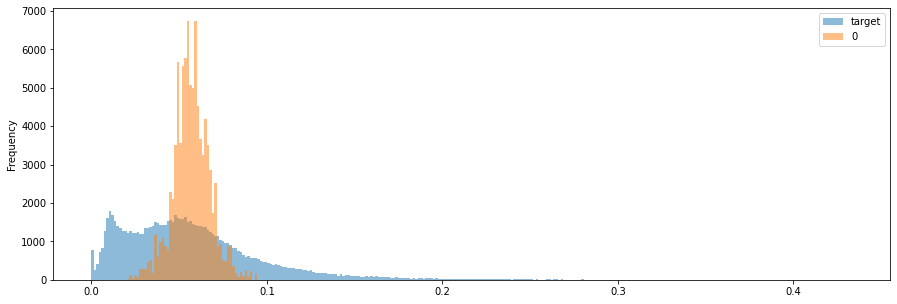

In [16]:
# Full train
params = load('best_params.json')

cv_params = {k:v for k,v in params.items() if k not in 
             ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state']}
cv_params
train_X, train_y = prep_data(cv_params, train)

est_params = {k:v for k,v in params.items() if k in 
             ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state']}
est_params
est = GradientBoostingRegressor()
_ = est.set_params(**est_params)
_ = est.fit(train_X, train_y)
pred = est.predict(train_X)
_ = concat([train_y, Series(pred)], axis=1).plot(kind='hist', bins=int(len(train)**0.5), figsize=(15,5), alpha=0.5)

# Submission
test_X = prep_data(cv_params, test, train_data=False)
pred = est.predict(test_X)
subm = concat([test['id'], Series(pred)], axis=1)
subm.columns = ['id', 'target']
subm.to_csv('submission.csv', index=False)

In [17]:
subm

,id,target
0,_wNsZEqpKUA_2021-12-01,0.031491
1,2jfbXZiE6Lc_2021-12-01,0.055457
2,F1Hq8eVOMHs_2021-12-01,0.030030
3,GQXVQmcGQUY_2021-12-01,0.031649
4,n4XojTb6pfs_2021-12-01,0.065061
...,...,...
5795,hJfpCXAMYPM_2021-12-30,0.030881
5796,MbmTMEYnEzo_2021-12-30,0.030838
5797,VG7arSAYvQI_2021-12-30,0.032702
5798,SNb-g-hNYYs_2021-12-30,0.060573


In [18]:
if False:
    def train_model(train_X, train_y, est, score, give_model=False, folds=False):
        if not give_model:
            if not folds:
                train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.8)
                est.fit(train_X, train_y)
                pred_v = est.predict(valid_X)
                obj = score(valid_y, pred_v)
                return obj
            else:
                ss = ShuffleSplit(n_splits=5, test_size=0.2)
                #ss = TimeSeriesSplit(n_splits=2)
                objs = []
                for train_idx, valid_idx in ss.split(train_X):
                    est.fit(train_X[train_idx, :], train_y.iloc[train_idx])
                    pred_v = est.predict(train_X[valid_idx, :])
                    obj = score(train_y.iloc[valid_idx], pred_v)
                    objs.append(obj)
                obj = mean(objs)
                return obj
        else:
            est.fit(train_X, train_y)
            return est